In [6]:
import tensorflow as tf

In [7]:
tf.__version__


'2.19.0'

In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [9]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000  # total images
BATCH_SIZE = 256
# Batch and shuffle the data, Converts NumPy array into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_images.shape[0] - 60,000

60000 → number of images

28 → height of each image

28 → width
1 - grey

Because 127.5 is the midpoint of 0 and 255.

convert to [-1,1]

/255 convert to [0 1]

input_shape=(100,)  - input noise

Noise (100)

   ↓ Dense

7×7×256

   ↓ Conv2DTranspose

7×7×128

   ↓ Conv2DTranspose


14×14×64

   ↓ Conv2DTranspose
   
28×28×1 (image)



Conv2DTranspose (used in Generator)

Increases image size

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    # first layer is dense adding vector of values
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


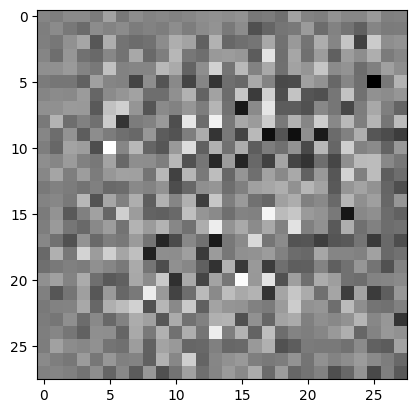

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00024341]], shape=(1, 1), dtype=float32)


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Binary Cross Entropy (BCE) is used for binary classification

Discriminator classifies:

Real image → 1

Fake image → 0

from_logits=True

Means the discriminator outputs raw values (logits), not sigmoid probabilities

TensorFlow internally applies sigmoid + BCE in a numerically stable way

Why logits?
Better gradient stability during GAN training.

In [15]:
# Learns to distinguish real images from fake ones
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # real label 1 so tf.ones
    # Penalizes the discriminator if it fails to classify real images as real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # fake lable 0 so tf. zeros
    # Penalizes the discriminator if it classifies fake images as real
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Generator wants to fool the discriminator

It wants fake images to be classified as real

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


Enables:

Resume training

Avoid retraining from scratch

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])   # Helps visually track generator improvement

EPOCHS	Full passes over dataset

noise_dim	Size of random noise vector

num_examples_to_generate	Images generated for visualization

Without @tf.function (Normal Python execution)

Code runs line by line

Python controls execution

Slower (especially loops)

Easier to debug

This is called Eager Execution.

With @tf.function (Compiled execution)

Code is traced once

Converted into a TensorFlow graph

Runs much faster

Optimized for CPU/GPU/TPU

This is called Graph Execution.

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
      # Records operations to compute gradients automatically

      # Two tapes:

      # gen_tape → Generator updates

      # disc_tape → Discriminator updates

      # Required for backpropagation

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator converts noise → fake images
      generated_images = generator(noise, training=True)

      # Discriminator sees:

      # Real images → real_output

      # Fake images → fake_output

      # Outputs are logits (raw values)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # ∂(generator loss) / ∂(generator weights)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # ∂(discriminator loss) / ∂(discriminator weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Updates generator weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Updates generator weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Records operations to compute gradients automatically

Two tapes:

gen_tape → Generator updates

disc_tape → Discriminator updates

Required for backpropagation

1. Generate noise
2. Generator → fake images
3. Discriminator → real & fake scores
4. Compute losses
5. Compute gradients
6. Update both networks


In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

For each epoch:

  For each batch:

    Train generator & discriminator
  Clear screen

  Generate images

  Save checkpoint (every 15 epochs)

  Print training time

After training:

  Generate final images


Trains the GAN for a given number of epochs

Calls train_step() for every batch

Generates images to monitor progress

Saves model checkpoints

In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

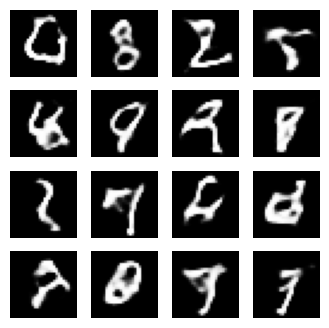

In [ ]:
train(train_dataset, EPOCHS)